In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import math
import torch
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
FILES_PATH = '/content/drive/My Drive/PlantDisease_Dataset/PlantVillage/Potato'

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    FILES_PATH,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
dataset.class_names
len(dataset)

68

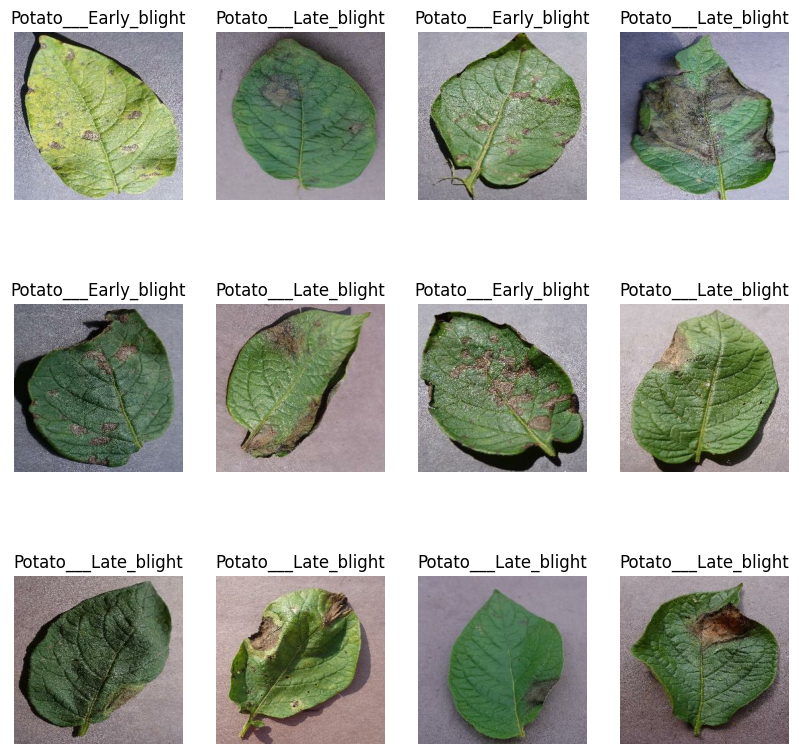

In [7]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(dataset.class_names[label_batch[i]])
    plt.axis("off")
  break

In [8]:
def split_dataset(ds, train_size = 0.8, val_size = 0.1, test_size = 0.1, shuffle = True, shuffle_size = 10000):

  if shuffle:
    ds.shuffle(shuffle_size, seed = 12)
  tr_ds_size = math.floor(len(ds)*train_size)
  train_ds = ds.take(tr_ds_size)
  test_ds = ds.skip(tr_ds_size)
  val_ds_size = math.floor(len(ds)*val_size)
  val_ds = test_ds.take(val_ds_size)
  test_ds = test_ds.skip(val_ds_size)


  return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [10]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3),activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dense(n_classes, activation = "softmax")

])

model.build(input_shape = input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [16]:
model.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = ["accuracy"])

In [17]:
checkpoint_path = "/content/drive/My Drive/PlantDisease_Dataset/PlantVillage/Models/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [18]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds,
    callbacks=[cp_callback]
)

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 0.9194 - accuracy: 0.4890
Epoch 1: saving model to /content/drive/My Drive/PlantDisease_Dataset/PlantVillage/Models/cp.ckpt
54/54 [==============================] - 236s 493ms/step - loss: 0.9194 - accuracy: 0.4890 - val_loss: 0.8419 - val_accuracy: 0.6719
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 0.7137 - accuracy: 0.6481
Epoch 2: saving model to /content/drive/My Drive/PlantDisease_Dataset/PlantVillage/Models/cp.ckpt
54/54 [==============================] - 4s 66ms/step - loss: 0.7137 - accuracy: 0.6481 - val_loss: 0.5237 - val_accuracy: 0.7604
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 0.4697 - accuracy: 0.7951
Epoch 3: saving model to /content/drive/My Drive/PlantDisease_Dataset/PlantVillage/Models/cp.ckpt
54/54 [==============================] - 4s 65ms/step - loss: 0.4697 - accuracy: 0.7951 - val_loss: 0.3370 - val_accuracy: 0.8490
Epoch 4/50
54/54 [=============

In [19]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 8s 20ms/step - loss: 0.0702 - accuracy: 0.9698


In [20]:
scores

[0.07022612541913986, 0.9698275923728943]

In [21]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


Text(0.5, 1.0, 'Training and Validation Loss')

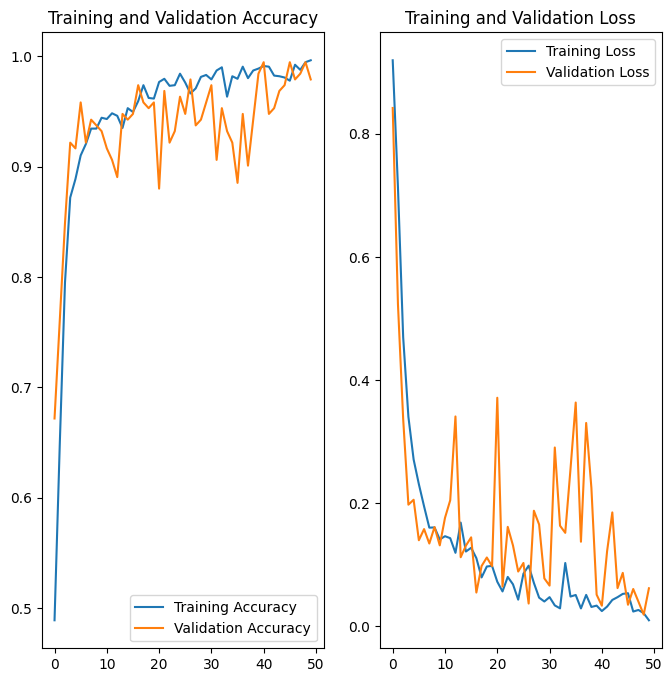

In [25]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend()
plt.title("Training and Validation Loss")


Label Before Prediction Potato___Early_blight
1/1 [==============================] - 0s 234ms/step
After Prediction:  Potato___Early_blight


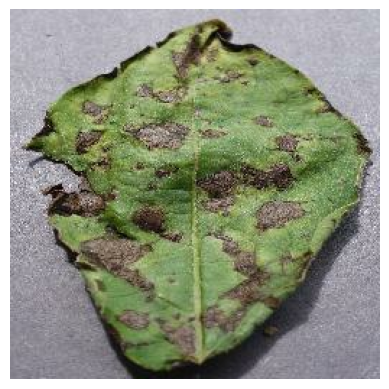

In [26]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
  plt.imshow(images_batch[0].numpy().astype("uint8"))
  print("Label Before Prediction " + dataset.class_names[labels_batch[0]])
  plt.axis("off")
  batch_prediction = model.predict(images_batch)
  print("After Prediction: ",dataset.class_names[np.argmax(batch_prediction[0])])
  break

In [27]:
def predict(model, image_batch):
  #image_array = tf.keras.preprocessing.image.img_to_array(image_batch[i].numpy())
  image_array = tf.keras.preprocessing.image.img_to_array(image_batch)

  image_array = tf.expand_dims(image_array,0)

  predictions = model.predict(image_array)
  predicted_class = dataset.class_names[np.argmax(predictions[0])]
  confidence = round(100*np.max(predictions[0]),2)

  return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


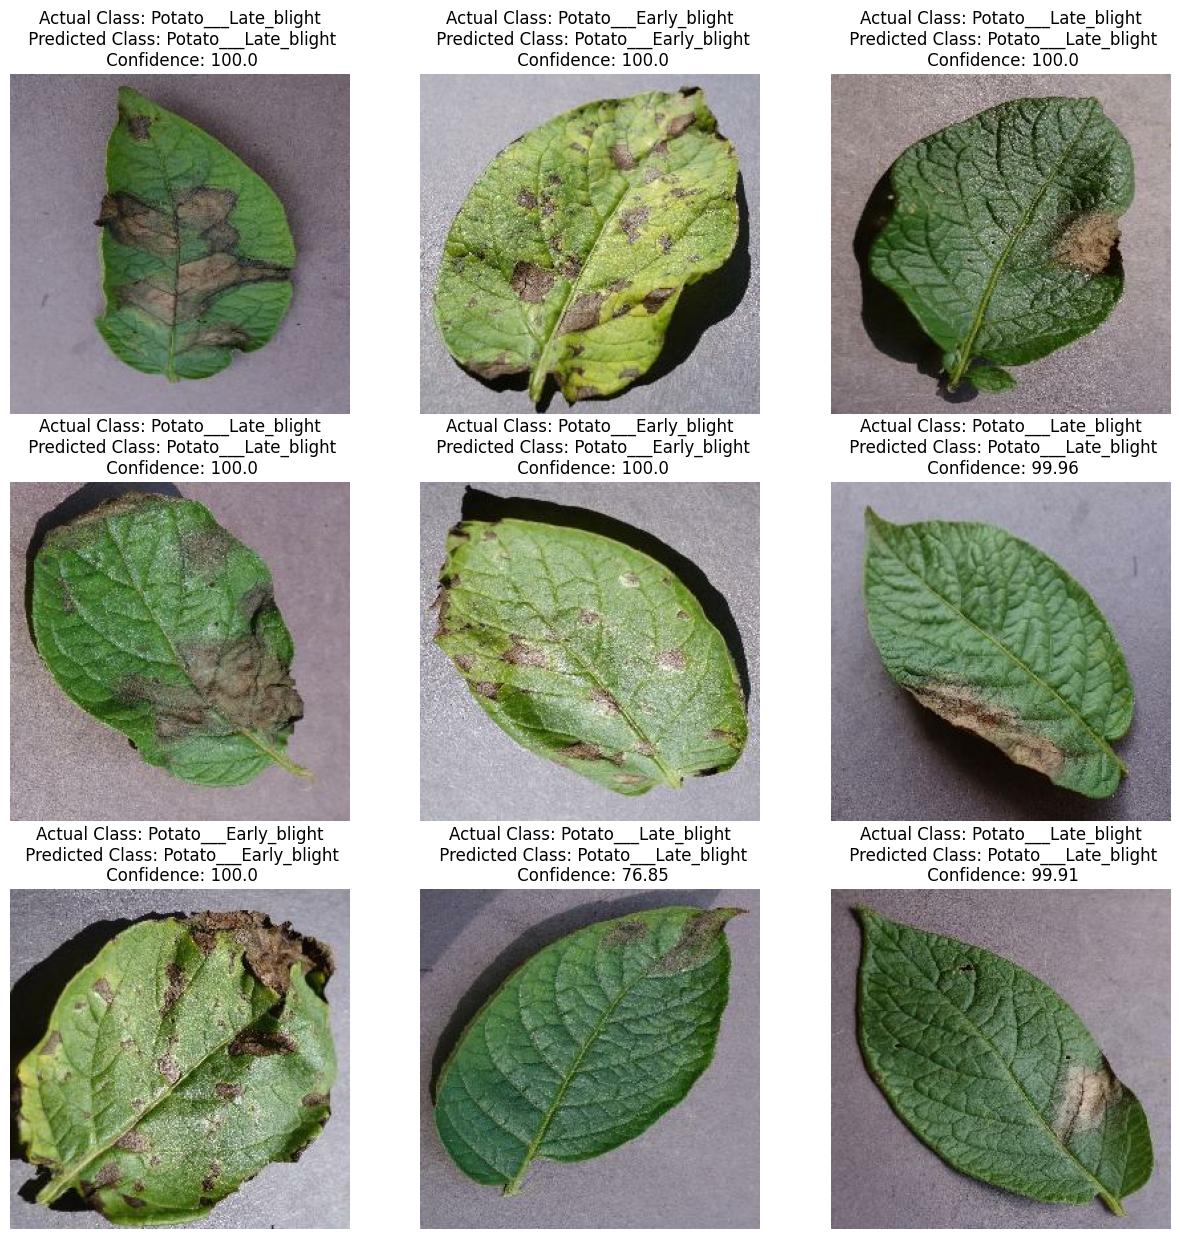

In [28]:
plt.figure(figsize = (15,15))
classlabels = dataset.class_names
for image_batch, labels_batch in test_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    #predicted_class, confidence = predict(model, image_batch)
    predicted_class, confidence = predict(model, image_batch[i].numpy())

    actual_label = classlabels[labels_batch[i]]
    plt.title("Actual Class: "+ actual_label+"\n Predicted Class: "+predicted_class + "\n Confidence: " + str(confidence))

    plt.axis("off")


In [29]:
model.save('/content/drive/My Drive/PlantDisease_Dataset/PlantVillage/Models')